$
\newcommand{\R}{\mathbb{R}}
\newcommand{\C}{\mathbb{C}}
\newcommand{\i}{\mathrm{i}}
%
\newcommand{\HP}{\mathcal{H}_P}
\newcommand{\HM}{\mathcal{H}_M}
\newcommand{\UP}{\mathcal{U}_P}
\newcommand{\UM}{\mathcal{U}_M}
%
\newcommand{\RX}{\mathrm{RX}}
\newcommand{\RZ}{\mathrm{RZ}}
\newcommand{\RZZ}{\mathrm{RZZ}}
\newcommand{\CX}{\mathrm{CX}}
\newcommand{\CNOT}{\mathrm{CNOT}}
%
\newcommand{\ket}[1]{\left\vert #1 \right\rangle}
\newcommand{\bra}[1]{\left\langle #1 \right\vert}
\newcommand{\braket}[1]{\left\langle #1 \right\rangle}
\newcommand{\pmat}[1]{\begin{pmatrix}#1\end{pmatrix}}
$

---

***This notebook is part of the project [SEQUOIA](https://websites.fraunhofer.de/sequoia/) of the [Competence Center Quantum Computing Baden-Württemberg](https://www.iaf.fraunhofer.de/en/networkers/KQC.html).***

---

<img src="images/sequoia_logo.png" />

<br>
<br>

# SEQUOIA DEMONSTRATOR  <a class="tocSkip"/>

## Energy Use Case: Optimization of Charging Schedules for Electric Cars  <a class="tocSkip"/>


Authors: Andreas Sturm, Niclas Schillo

---
# Bonus Notebook: Improving QAOA with CVaR <a class="tocSkip">

In Notebook 2 we saw that the variational parameters $\vec{\beta}$ and $\vec{\gamma}$ of QAOA are determined with a classical optimizer such that they minimize the expectation value $e(\vec{\beta}, \vec{\gamma})$:

$$
(\vec{\beta}^\ast, \vec{\gamma}^\ast) = \mathrm{argmin}_{\vec{\beta}, \vec{\gamma}} e(\vec{\beta}, \vec{\gamma}) \ ,
\qquad
e(\vec{\beta}, \vec{\gamma})
=
\langle \psi_\mathrm{QAOA}(\vec{\beta}, \vec{\gamma}) | \HP |\psi_\mathrm{QAOA}(\vec{\beta}, \vec{\gamma}) \rangle
\ .
$$


Then, in Notebook 3 we saw that this (usually) does not yield a quantum state 

$$
|\psi_\mathrm{QAOA}(\vec{\beta}^\ast, \vec{\gamma}^\ast) \rangle
= \sum_{\vec{b} \in \{0, 1\}^n}
\lambda_{b} |b\rangle \ ,
$$

where the probability $|\lambda_{b^\ast}|^2$ of the exact solution bit string $b^\ast$ is the highest among all probabilities in $|\psi_\mathrm{QAOA}(\vec{\beta}^\ast, \vec{\gamma}^\ast) \rangle$:

$$
|\lambda_{b^\ast}|^2 \not = \max_{\vec{b} \in \{0, 1\}^n} |\lambda_{b}|^2,
\qquad
\lambda_{b^\ast} = \mathrm{argmin}_{\vec{b} \in \{0, 1\}^n} f_3(\vec{b}) \ .
$$

If one is interested in this exact solution (and not an approximate solution) it can be beneficial to use the **Conditional Value at Risk (CVaR) expectation value** instead of the usual expectation value.

In this notebook we present how the CVaR expecation can be integrated in our codes and present some results comparing standard and CVaR QAOA.

Remark: CVaR QAOA was proposed in [1].

# Example for this Notebook

For this notebook we use the same example as in Notebook 2.

In [1]:
import os
os.environ["QISKIT_SETTINGS"] = "qiskitrc"

In [2]:
from codes_notebook_1 import generate_example
charging_unit, car_green, qcio, converter, qubo, number_binary_variables, qubo_minimization_result = generate_example()

In [3]:
f_3_min = qubo_minimization_result.fval
print("minimum value: f_3(b_min) = ", f_3_min)

minimum value: f_3(b_min) =  5.999999999999993


In [4]:
from qiskit.circuit.library import QAOAAnsatz

ising, ising_offset = qubo.to_ising()

qaoa_reps = 2
qaoa_ansatz = QAOAAnsatz(cost_operator=ising, reps=qaoa_reps, name='qaoa')
qaoa_ansatz.measure_active()

In [5]:
from qiskit_aer import AerSimulator

number_of_shots = 10000
aer_simulator = AerSimulator(method="statevector", shots=number_of_shots)

## Standard Expectation Value

We already presented in Notebook 2 how the standard expectation function can be implemented (and also commented on the naming "energy_evaluation"). We repeat it here so that we can later compare it with CVaR.

In [6]:
from typing import List
import numpy as np
from qiskit.opflow import OperatorStateFn

observable = OperatorStateFn(ising, is_measurement=True)

def energy_evaluation(parameter_values: List[float]):
    "parameter_values is expected to be of the form [beta_0, beta_1, ..., gamma_0, gamma_1, ...]"
    parameter_bindings = dict(zip(qaoa_ansatz.parameters, parameter_values))

    qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)
    qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=3)

    result = aer_simulator.run(qaoa_with_parameters_decomposed).result()
    counts = result.get_counts()
    sqrt_probabilities = {bitstring: np.sqrt(count/number_of_shots) for bitstring, count in counts.items()}
    
    expectation = np.real(observable.eval(sqrt_probabilities)) + ising_offset
    
    return expectation

In [7]:
print(f"Standard expectation value e([1.23, 2.31, 3.21, 4.32]) = {energy_evaluation([1.23, 2.31, 3.21, 4.32])}")

Standard expectation value e([1.23, 2.31, 3.21, 4.32]) = 38.81870000000001


# Conditional Value at Risk (CVaR) Expectation

In many optimization problems the smallest possible value of the cost function is of central intereset. Therefore, it seems reasonable to use the best observed sample as the cost function in QAOA. However, this leads to an unsmooth optimization surface and hence to problems in the classical optimization. As a remedy the optimization surface can be smoothed by not only using the best observed sample but instead averaging over a subset of the best observed samples. Exactly this is the basis of the CVaR method, and using it should lead to faster convergence of the classical optimizer and to better QAOA solutions.

In order to specify the fraction of the best-observed samples, which are used to compute the objective function, the real number $\alpha \in [0, 1]$ is introduced. If $\alpha = 1$, CVaR is equivalent to a standard expectation value. If $\alpha = 0$, only the best-observed sample is used.

In the next code cells we implement the CVaR expectation with qiskit's class `CVaRExpectation`, see [link](https://qiskit.org/documentation/stubs/qiskit.opflow.expectations.CVaRExpectation.html).

In [8]:
cvar_alpha = 0.08

In [9]:
from qiskit.opflow import CircuitStateFn, DictStateFn
from qiskit.opflow.expectations import CVaRExpectation

qaoa_ansatz_wo_measurement = qaoa_ansatz.copy()
qaoa_ansatz_wo_measurement.remove_final_measurements()

expectation_operator = observable @ CircuitStateFn(qaoa_ansatz_wo_measurement)

cvar_expectation_converter = CVaRExpectation(alpha=cvar_alpha)
expectation_operator_cvar = cvar_expectation_converter.convert(expectation_operator)
measurement_cvar = expectation_operator_cvar[0]

def energy_evaluation_cvar(parameter_values: List[float]):
    "parameter_values is expected to be of the form [beta_0, beta_1, ..., gamma_0, gamma_1, ...]"
    parameter_bindings = dict(zip(qaoa_ansatz.parameters, parameter_values))

    qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)
    qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=3)

    result = aer_simulator.run(qaoa_with_parameters_decomposed).result()
    counts = result.get_counts()
    sqrt_probabilities = {bitstring: np.sqrt(count/number_of_shots) for bitstring, count in counts.items()}
    sqrt_probabilities_dict_state = DictStateFn(sqrt_probabilities)
    
    expectation = np.real(measurement_cvar.eval(sqrt_probabilities_dict_state)) + ising_offset
    
    return expectation

In [10]:
print(f"CVaR expectation value e_cvar([1.23, 2.31, 3.21, 4.32]) = {energy_evaluation_cvar([1.23, 2.31, 3.21, 4.32])}")

CVaR expectation value e_cvar([1.23, 2.31, 3.21, 4.32]) = 9.024500000000003


Next, we use a classical optimizer to determine the variational parameters $\vec{\beta}$ and $\vec{\gamma}$. This follows the same steps as in Notebook 2.

# Classical Optimization

In [11]:
# Run this cell only once if you want changing random numbers in the cell below
seed = 199
random_generator = np.random.default_rng(seed)

In [12]:
from qiskit.algorithms.optimizers import COBYLA

cobyla_optimizer = COBYLA()

betas_initial_guess = np.pi*random_generator.random(qaoa_reps)
gammas_initial_guess = 2*np.pi*random_generator.random(qaoa_reps)
parameter_values_initial_guess = [*betas_initial_guess, *gammas_initial_guess]

In [13]:
result_optimization = cobyla_optimizer.minimize(fun=energy_evaluation, x0=parameter_values_initial_guess)

parameter_values_optimized = result_optimization.x
energy_optimized = result_optimization.fun
number_function_evaluations = result_optimization.nfev # Number of evalutions of energy_evaluation

print("Standard:")
print("  optimized parameters:", parameter_values_optimized)
print("  expectation value:", energy_optimized)
print("  number function evaluations:", number_function_evaluations)

Standard:
  optimized parameters: [2.10537365 2.9363235  0.45141433 1.85876465]
  expectation value: 18.86292000000001
  number function evaluations: 47


In [14]:
result_optimization_cvar = cobyla_optimizer.minimize(fun=energy_evaluation_cvar, x0=parameter_values_initial_guess)

parameter_values_optimized_cvar = result_optimization_cvar.x
energy_optimized_cvar = result_optimization_cvar.fun
number_function_evaluations_cvar = result_optimization_cvar.nfev # Number of evalutions of energy_evaluation_cvar

print(f"CVaR, alpha={cvar_alpha}:")
print("  optimized parameters:", parameter_values_optimized_cvar)
print("  cvar expectation value:", energy_optimized_cvar)
print("  number function evaluations:", number_function_evaluations_cvar)

CVaR, alpha=0.08:
  optimized parameters: [1.96361184 2.81734039 0.32297973 1.9298287 ]
  cvar expectation value: 6.000000000000011
  number function evaluations: 30


# Postprocessing

As in Notebook 3 we collect our result in a pandas dataframe, postprocess it and then visualize it.

In [15]:
parameter_bindings = dict(zip(qaoa_ansatz.parameters, parameter_values_optimized))

qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)
qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=3)

result = aer_simulator.run(qaoa_with_parameters_decomposed).result()
counts = result.get_counts()

In [16]:
parameter_bindings = dict(zip(qaoa_ansatz.parameters, parameter_values_optimized_cvar))

qaoa_with_parameters = qaoa_ansatz.bind_parameters(parameter_bindings)
qaoa_with_parameters_decomposed = qaoa_with_parameters.decompose(reps=3)

result = aer_simulator.run(qaoa_with_parameters_decomposed).result()
counts_cvar = result.get_counts()

In [17]:
import pandas as pd

df = pd.DataFrame.from_dict(data={
    "bit_string": counts.keys(),
    "count": counts.values()})
df["probability"] = df["count"]/number_of_shots

df_cvar = pd.DataFrame.from_dict(data={
    "bit_string": counts_cvar.keys(),
    "count_cvar": counts_cvar.values()})
df_cvar["probability_cvar"] = df_cvar["count_cvar"]/number_of_shots

df = df.merge(df_cvar, how="outer", on="bit_string")
df.fillna(0.0, inplace=True)

df

,bit_string,count,probability,count_cvar,probability_cvar
0,00001010,2.0,0.0002,83.0,0.0083
1,11101000,1.0,0.0001,18.0,0.0018
2,00111101,4.0,0.0004,14.0,0.0014
3,11101111,2.0,0.0002,51.0,0.0051
4,00101000,7.0,0.0007,86.0,0.0086
...,...,...,...,...,...
251,01101110,0.0,0.0000,12.0,0.0012
252,00101011,0.0,0.0000,53.0,0.0053
253,10111010,0.0,0.0000,17.0,0.0017
254,00101110,0.0,0.0000,41.0,0.0041


In [18]:
df["bit_array"] = df["bit_string"].apply(
    lambda bitstring: np.fromiter(bitstring, dtype=int)[::-1])

df["integer_array"] = df["bit_array"].apply(
    converter.interpret)

df = df[
    ["bit_string", "bit_array","integer_array", "count", "probability", "probability_cvar"]]

df["cost"] = df["bit_array"].apply(
    qubo.objective.evaluate)

df["is_feasible"] = df["integer_array"].apply(
    qcio.is_feasible)

df["is_optimal"] = df["cost"].apply(lambda x: np.isclose(x, f_3_min))

df = df.sort_values("cost", ascending=True)

df.reset_index(inplace=True, drop=True)

df

,bit_string,bit_array,integer_array,count,probability,probability_cvar,cost,is_feasible,is_optimal
0,00011001,"[1, 0, 0, 1, 1, 0, 0, 0]","[1.0, 2.0, 1.0, 0.0]",156.0,0.0156,0.0321,6.0,True,True
1,00010110,"[0, 1, 1, 0, 1, 0, 0, 0]","[2.0, 1.0, 1.0, 0.0]",132.0,0.0132,0.0344,6.0,True,True
2,00100101,"[1, 0, 1, 0, 0, 1, 0, 0]","[1.0, 1.0, 2.0, 0.0]",136.0,0.0136,0.0343,6.0,True,True
3,00010101,"[1, 0, 1, 0, 1, 0, 0, 0]","[1.0, 1.0, 1.0, 0.0]",259.0,0.0259,0.0189,6.6,False,False
4,01010110,"[0, 1, 1, 0, 1, 0, 1, 0]","[2.0, 1.0, 1.0, 1.0]",83.0,0.0083,0.0066,7.0,True,False
...,...,...,...,...,...,...,...,...,...
251,11101111,"[1, 1, 1, 1, 0, 1, 1, 1]","[3.0, 3.0, 2.0, 3.0]",2.0,0.0002,0.0051,88.6,False,False
252,00111111,"[1, 1, 1, 1, 1, 1, 0, 0]","[3.0, 3.0, 3.0, 0.0]",9.0,0.0009,0.0172,117.0,False,False
253,01111111,"[1, 1, 1, 1, 1, 1, 1, 0]","[3.0, 3.0, 3.0, 1.0]",1.0,0.0001,0.0035,118.0,False,False
254,10111111,"[1, 1, 1, 1, 1, 1, 0, 1]","[3.0, 3.0, 3.0, 2.0]",2.0,0.0002,0.0062,121.0,False,False


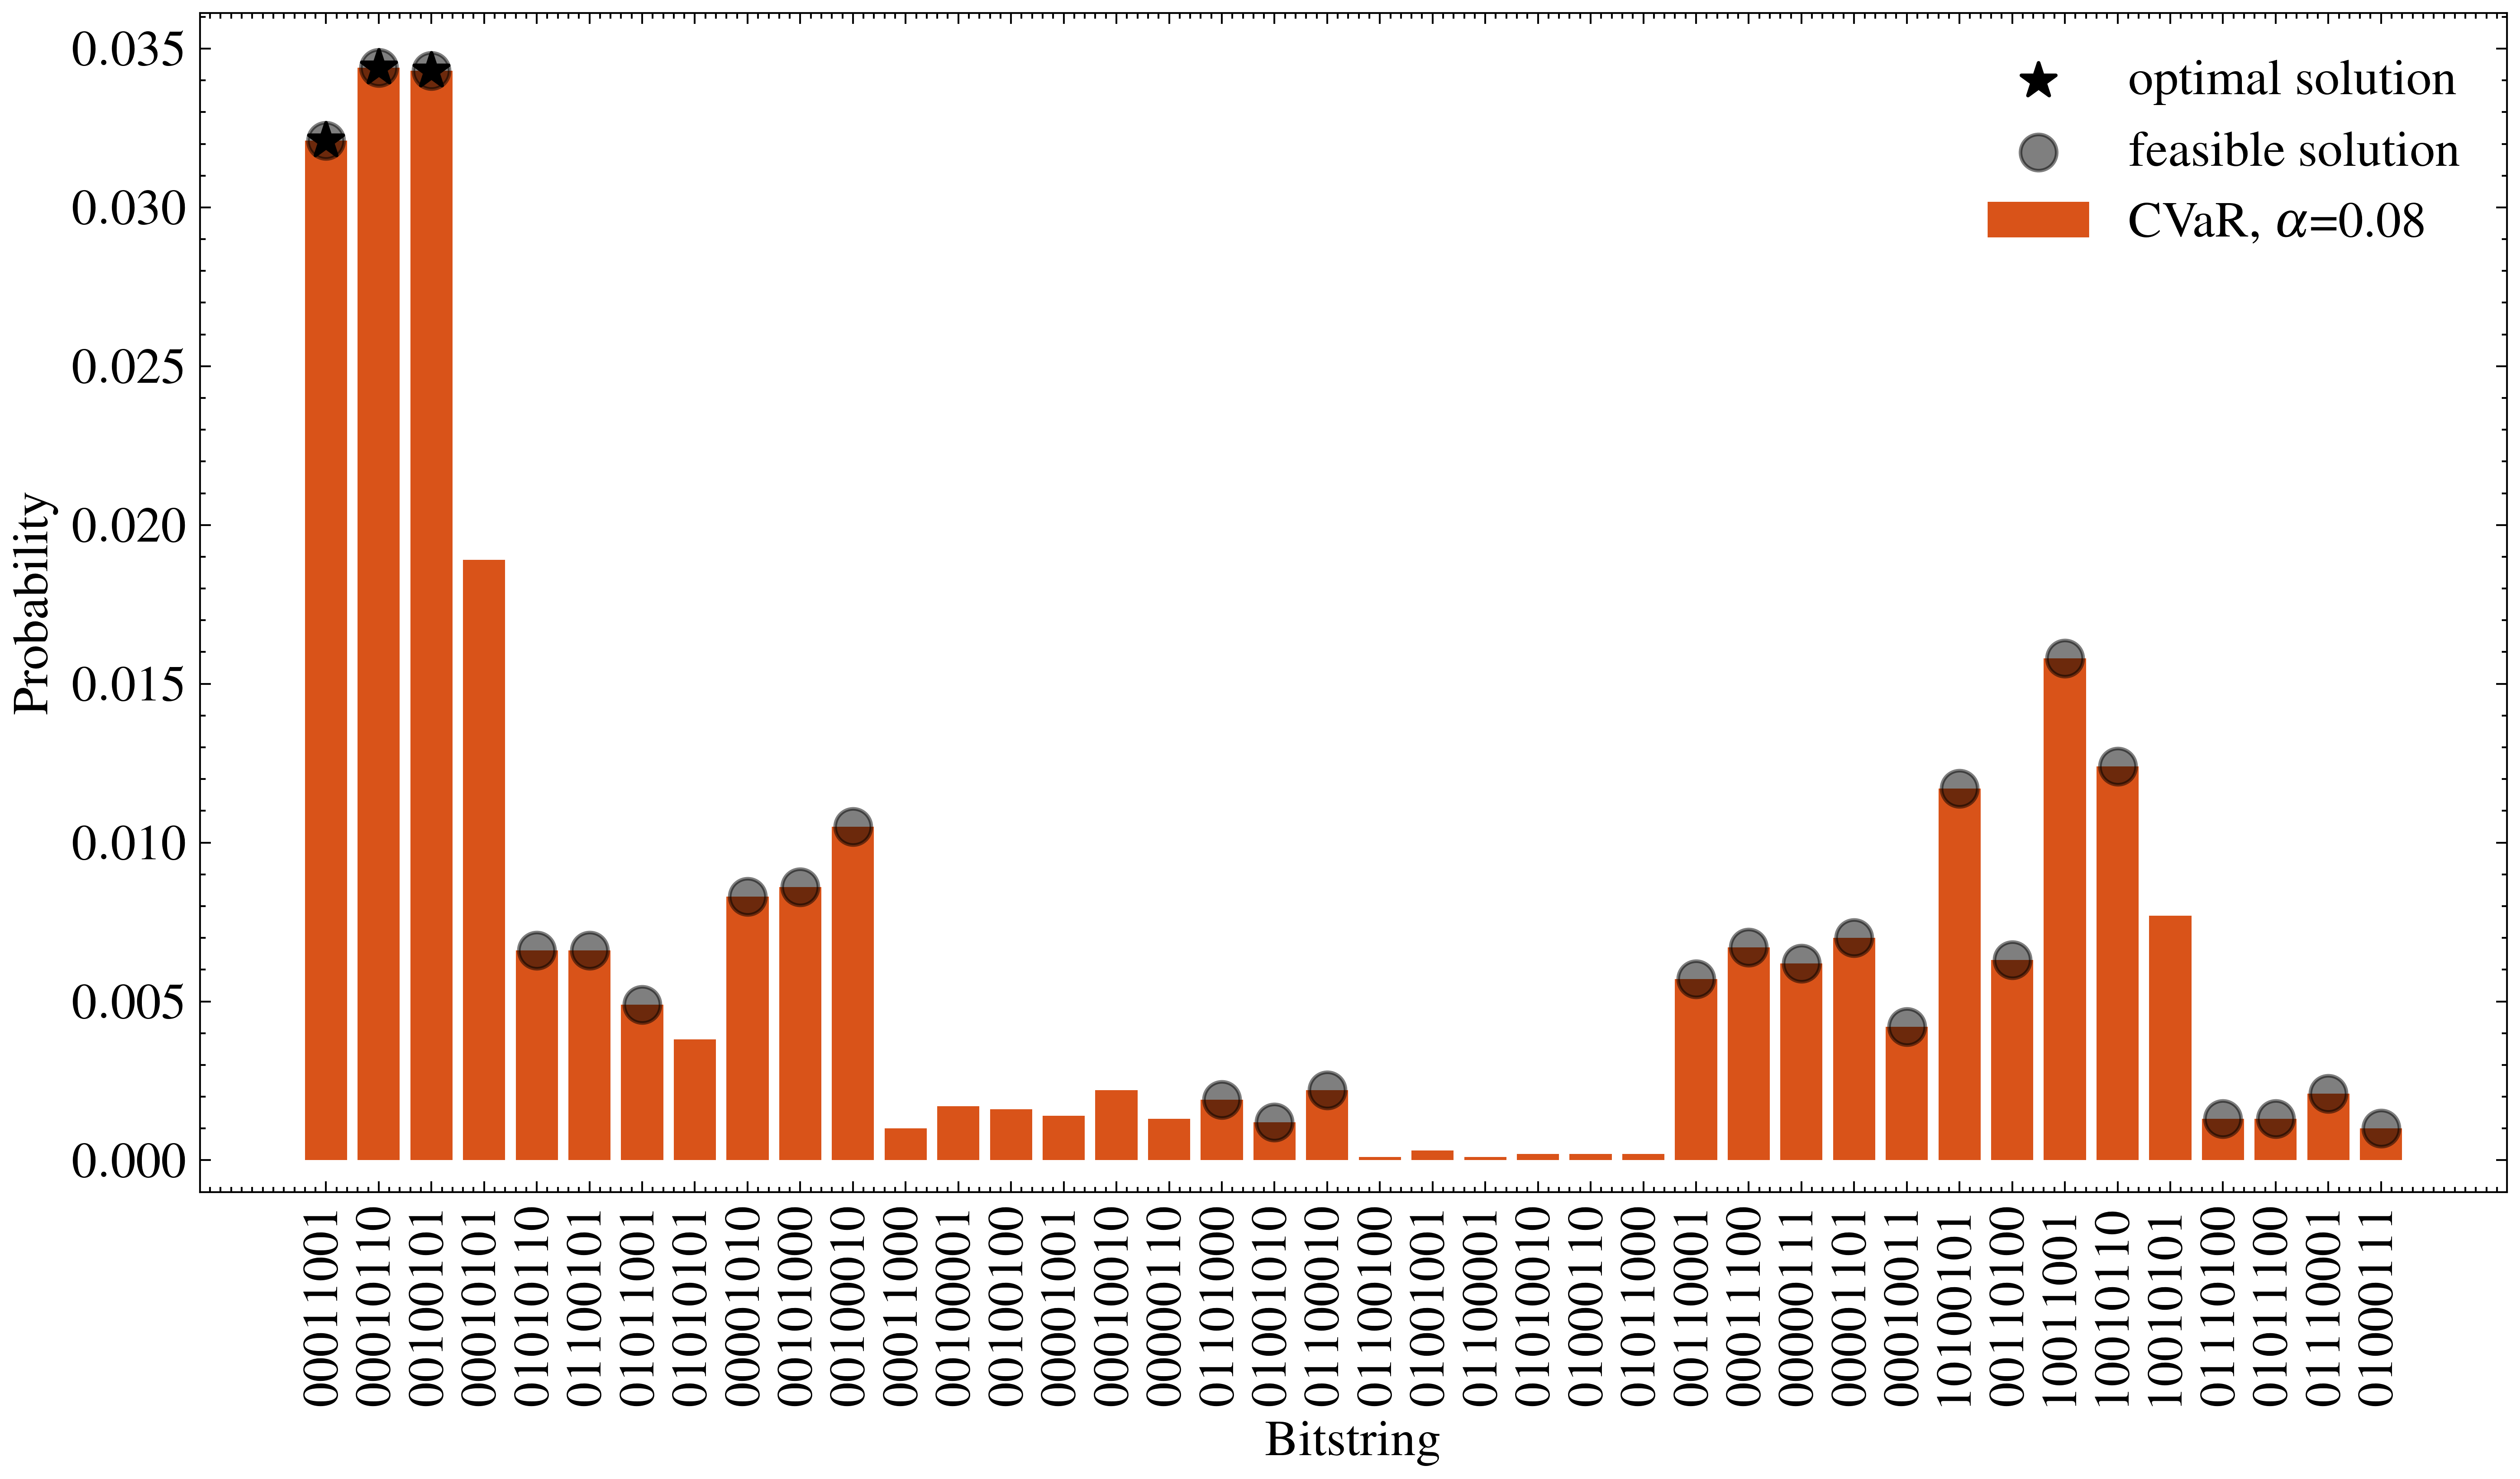

In [70]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
# Set the default figure size and font size
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE,RED])

        
df_plot = df.iloc[0:40, :]

#use IEEE Colors
BLUE = "#0072BD"
RED = "#D95319"
GREEN = "#77AC30"

fig, ax =  plt.subplots()


ax.bar(df_plot.index, df_plot["probability_cvar"], color= RED, label=f"CVaR, $\\alpha$={cvar_alpha}")

ax.set_xlabel("Bitstring")
ax.set_ylabel("Probability")
ax.set_xticks(df_plot.index)
ax.set_xticklabels(df_plot["bit_string"], rotation=90)
ax.legend()
# add scatter markers above x labels to indicate the optimal solution and feasible solutions
ax.scatter(df_plot[df_plot["is_optimal"]].index, df_plot[df_plot["is_optimal"]]["probability_cvar"], marker="*", color="black", s=100, label="optimal solution")
ax.scatter(df_plot[df_plot["is_feasible"]].index, df_plot[df_plot["is_feasible"]]["probability_cvar"], marker="o",alpha=0.5 ,color="black", s=100, label="feasible solution")
#remove overllaping markers

ax.set_ylim(bottom=-0.001)
ax.legend()


#move the x axis a little bit up
ax.set_ylim(bottom=-0.001)
   
ax.legend()
plt.tight_layout()
    
            
    
    


                



plt.savefig("qaoa_cvar.pdf", bbox_inches='tight')
plt.show()
    


In [43]:
fig.add_trace(go.Bar(
    x=df_plot["bit_string"],
    y=df_plot["probability"],
    name="standard",
    marker_color=RED
    
))
#fig.add_trace(go.Bar(
#    x=df_plot["bit_string"],
 #   y=df_plot["probability_cvar"],
#    name="cvar"
#))
fig.add_trace(go.Scatter(
    x=df_plot["bit_string"][df_plot["is_optimal"]==True],
    y=[-0.001]*(len(df_plot["is_optimal"]==True)),
    mode="markers",
    marker_symbol="arrow-up",
    marker_size=15,
    name="optimal bitstring",
    opacity=0.9
))
fig.add_trace(go.Scatter(
    x=df_plot["bit_string"][df_plot["is_feasible"]==True],
    y=[-0.001]*(len(df_plot["is_feasible"]==True)),
    mode="markers",
    marker_symbol="arrow-up",
    marker_size=10,
    name="feasible bitstring",
    opacity=0.7
))
fig.update_xaxes(
    title=r'$x$')
fig.update_yaxes(
    title="probability")
fig.update_layout(
    title="Best 50 bit strings w.r.t. to cost function (sorted by cost, increasing from left to right)",
    title_font_size=13
)

fig.show()
fig.write_image("qaoa_cvar.pdf")

In [42]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(
    x=df_plot["bit_string"],
    y=df_plot["probability"],
    name="standard"
))
fig.add_trace(go.Bar(
    x=df_plot["bit_string"],
    y=df_plot["probability_cvar"],
    name="cvar"
))

fig.add_trace(go.Scatter(
    x=df_plot["bit_string"],
    y=df_plot["cost"],
    mode="lines+markers",
    line_color="black",
    line_width=2,
    name="cost"),
secondary_y=True
)

fig.update_xaxes(
    title="bit string")
fig.update_yaxes(
    title="probability")
fig.update_yaxes(
    title="cost",
    secondary_y=True)
fig.update_layout(
    title="Best 50 bit strings w.r.t. to cost function",
    title_font_size=13
)

# Further Examples

## Convergence Classical Optimizer

In [21]:
var_parameters_list = []
def callback(*args):
    var_parameters_list.append(args)
    
var_parameters_cvar_list = []
def callback_cvar(*args):
    var_parameters_cvar_list.append(args)

cobyla_optimizer = COBYLA(callback=callback)
res = cobyla_optimizer.minimize(fun=energy_evaluation, x0=parameter_values_initial_guess)

cobyla_optimizer = COBYLA(callback=callback_cvar)
res_cvar = cobyla_optimizer.minimize(fun=energy_evaluation_cvar, x0=parameter_values_initial_guess)

In [22]:
expectation_values = [energy_evaluation(var_parameters[0]) for var_parameters in var_parameters_list]
expectation_values_cvar = [energy_evaluation_cvar(var_parameters[0]) for var_parameters in var_parameters_cvar_list] 

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=expectation_values,
    name="expectation value"))
fig.add_trace(go.Scatter(
    y=expectation_values_cvar,
    name="cvar expectation value"))
fig.update_xaxes(
    title="iteration")
fig.update_layout(
    title="Convergence classical optimizer",
    title_font_size=12)

## Further Examples

The following section examines the behavior for different $\alpha$.

For $\alpha = 0$:

<img src="images/cvar/alpha_0.svg" width="1500" />

For $\alpha = 0.2$:

<img src="images/cvar/alpha_0p2.svg" width="1500" />

For $\alpha = 0.4$:

<img src="images/cvar/alpha_0p4.svg" width="1500" />

For $\alpha = 0.6$:

<img src="images/cvar/alpha_0p6.svg" width="1500" />

For $\alpha = 0.8$:

<img src="images/cvar/alpha_0p8.svg" width="1500" />

For $\alpha = 1$:

<img src="images/cvar/alpha_1.svg" width="1500" />

# Literature <a class="tocSkip"/>

[1] *Barkoutsos, P. K., Nannicini, G., Robert, A., Tavernelli, I., and Woerner, S. 2020. Improving
Variational Quantum Optimization using CVaR. Quantum 4, 256*, see [link](https://arxiv.org/abs/1907.04769).

---
Authors: <br>
Andreas Sturm, andreas.sturm@iao.fraunhofer.de <br>
Niclas Schillo, niclas.schillo@iao.fraunhofer.de

(c) Fraunhofer IAO

---